In [1]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 492.9 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.8/750.8 kB 4.9 MB/s eta 0:00:0000:0100:01


In [2]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 1.4 MB/s eta 0:00:00 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 3.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 22.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [3]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=84cfbc05ac08347e8b860034c22e52a1092a6a893e12bba65ce7ce70246d25a6
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [4]:
import numpy as np
import pandas as pd
import os

import random

import torch
import os
from IPython.display import Image, clear_output

import glob 
import cv2 
from PIL import Image
import yaml

from matplotlib import pyplot as plt

from PIL import ImageDraw

from ultralytics import YOLO

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 2.1.2 (Tesla T4)


In [5]:
class Config:
    INPUT_PATH = '/kaggle/input'
    OUTPUT_PATH = '/kaggle/working'
    DATASET_NAME = 'car-plate-dataset-roboflow'
    TRAINING_IMAGES_PATH = f'{INPUT_PATH}/{DATASET_NAME}/train/images/'
    LABELS_TRAINING_PATH =  f'{INPUT_PATH}/{DATASET_NAME}/train/labels/'
    TESTING_IMAGES_PATH = f'{INPUT_PATH}/{DATASET_NAME}/test/images'
    YAML_PATH =  f'{INPUT_PATH}/{DATASET_NAME}/data.yaml'

In [6]:
print(f'DATASET_NAME = {Config.DATASET_NAME}')
print(f'DATASET_PATH = {Config.INPUT_PATH}/{Config.DATASET_NAME}')
print(f'TRAINING_IMAGES_PATH = {Config.TRAINING_IMAGES_PATH}')
print(f'LABELS_TRAINING_PATH = {Config.LABELS_TRAINING_PATH}')
print(f'YAML_PATH = {Config.YAML_PATH}')

DATASET_NAME = car-plate-dataset-roboflow
DATASET_PATH = /kaggle/input/car-plate-dataset-roboflow
TRAINING_IMAGES_PATH = /kaggle/input/car-plate-dataset-roboflow/train/images/
LABELS_TRAINING_PATH = /kaggle/input/car-plate-dataset-roboflow/train/labels/
YAML_PATH = /kaggle/input/car-plate-dataset-roboflow/data.yaml


In [7]:
class Utils:
    @staticmethod
    def load_images(folder):
        images = []
        for filename in os.listdir(folder):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path)
            images.append(img)
        return images
    
    
    @staticmethod
    def load_labels(folder):
        labels = []

        for filename in os.listdir(folder):
            if filename.endswith(".txt"):
                label_path = os.path.join(folder, filename)
                with open(label_path, 'r') as label_file:
                    label_data = []
                    for line in label_file:
                        label_info = list(map(float, line.strip().split()))
                        label_data.append(label_info)
                
                labels.append(label_data)

        return labels
    
    
    @staticmethod
    def load_classes(yaml_path):
        with open(yaml_path, 'r') as yaml_file:
            config = yaml.safe_load(yaml_file)
            class_names = config['names']

        return class_names
    
    
    @staticmethod
    def plot_random_images(images, rows, cols):
        num_images = rows * cols
        i = 0
        j = 0
        fig, axes = plt.subplots(rows, cols, figsize=((rows * rows), cols))
        for image in images:
            axes[i, j].imshow(image)
            axes[i, j].axis('off')
            j = j + 1
            if j == cols:
                j = 0
                i = i + 1
            if i == rows:
                break
        plt.tight_layout()
        plt.show()

img_shape = (416, 416, 3)
label_example = [[0.0, 0.18366372676341663, 0.5612940571668802, 0.19259335969555133, 0.1293641109416668], [1.0, 0.4951923076923077, 0.49038461538461536, 0.9903846153846154, 0.9807692307692307]]
classes = ['0', '1']


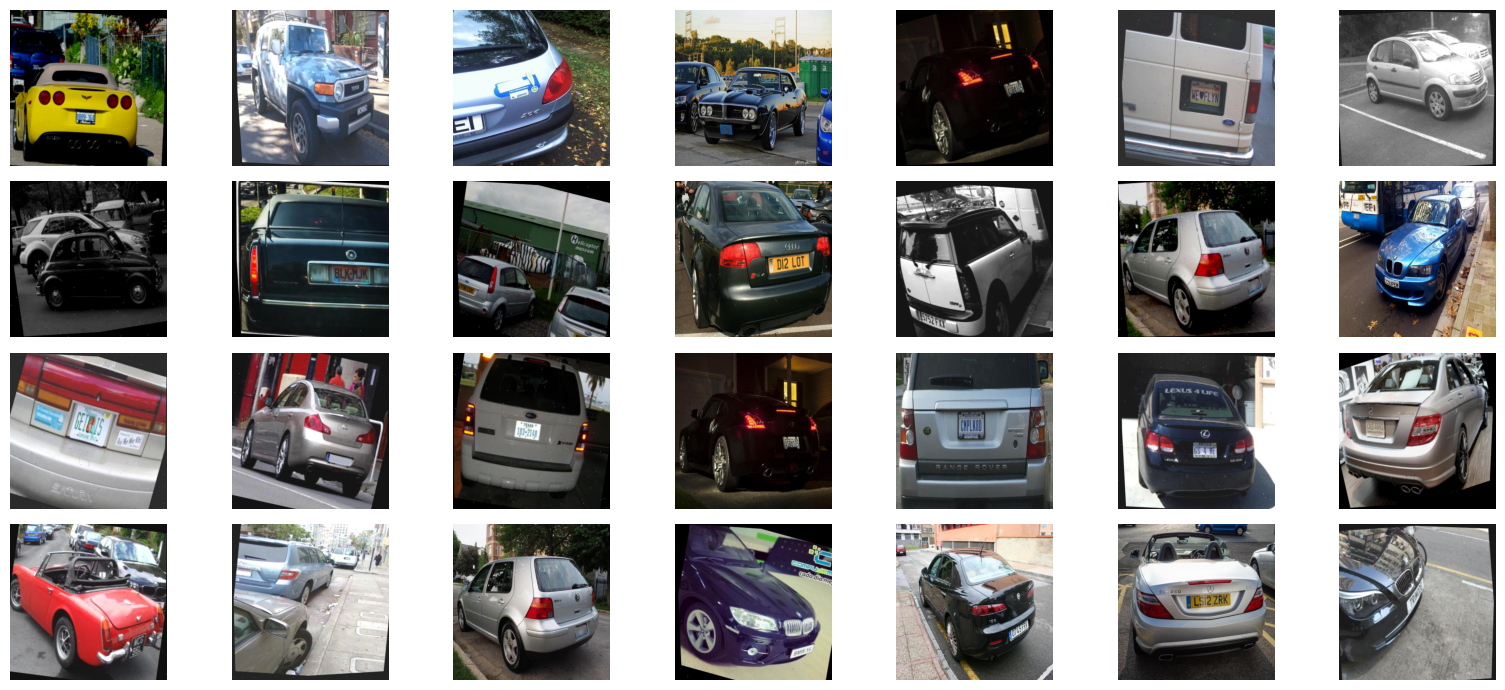

In [8]:
training_images = Utils.load_images(Config.TRAINING_IMAGES_PATH)
training_labels = Utils.load_labels(Config.LABELS_TRAINING_PATH)
classes = Utils.load_classes(Config.YAML_PATH)

img_example = np.array(training_images[0])
img_example = cv2.cvtColor(img_example, cv2.COLOR_RGB2BGR)
img_shape = img_example.shape
print(f'img_shape = {img_shape}')

label_example = training_labels[0]
print(f'label_example = {label_example}')

print(f'classes = {classes}')

# plotting random training images
Utils.plot_random_images(
    training_images,
    4,
    7
)

In [9]:
model = YOLO('yolov8n.pt')
print(model)

100%|██████████| 6.23M/6.23M [00:00<00:00, 75.9MB/s]

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [10]:
model.train(
    data = Config.YAML_PATH,
    epochs = 100,
    imgsz = img_shape[0],
    device = 0
)

Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/input/car-plate-dataset-roboflow/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

100%|██████████| 755k/755k [00:00<00:00, 11.9MB/s]
2024-04-23 10:50:36.328431: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-23 10:50:36.328543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-23 10:50:36.486852: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/input/car-plate-dataset-roboflow/train/labels... 735 images, 0 backgrounds, 0 corrupt: 100%|██████████| 735/735 [00:00<00:00, 916.07it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/car-plate-dataset-roboflow/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/car-plate-dataset-roboflow/valid/labels... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 299.44it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/car-plate-dataset-roboflow/valid is not writeable, cache not saved.


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.07G      1.243      2.064      1.363         84        416: 100%|██████████| 46/46 [00:10<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]

                   all         70        218      0.745      0.315       0.64      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.02G       1.24       1.33      1.361        108        416: 100%|██████████| 46/46 [00:05<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.70it/s]

                   all         70        218      0.657      0.456      0.596       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.01G      1.255      1.275      1.358         77        416: 100%|██████████| 46/46 [00:05<00:00,  8.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.69it/s]

                   all         70        218      0.602      0.602      0.642      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.01G      1.216      1.179      1.352        106        416: 100%|██████████| 46/46 [00:05<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.29it/s]

                   all         70        218       0.65      0.601      0.641      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.01G      1.221      1.132      1.335         74        416: 100%|██████████| 46/46 [00:05<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.88it/s]

                   all         70        218       0.62      0.599      0.606       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.01G      1.184      1.083      1.317         85        416: 100%|██████████| 46/46 [00:05<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.56it/s]

                   all         70        218      0.756       0.68      0.738      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.01G      1.169      1.033      1.294         80        416: 100%|██████████| 46/46 [00:05<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.74it/s]

                   all         70        218      0.722      0.553      0.607      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.01G      1.149       1.03      1.295         85        416: 100%|██████████| 46/46 [00:05<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.14it/s]

                   all         70        218      0.741      0.661      0.679      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.01G      1.129     0.9594      1.264         85        416: 100%|██████████| 46/46 [00:05<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.07it/s]

                   all         70        218      0.812      0.619      0.721       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.02G      1.125     0.9776       1.27         90        416: 100%|██████████| 46/46 [00:05<00:00,  8.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

                   all         70        218      0.847      0.672      0.775      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.01G      1.098     0.9315      1.267         65        416: 100%|██████████| 46/46 [00:05<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.34it/s]

                   all         70        218      0.806      0.641      0.719      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.01G      1.081     0.8953      1.243         98        416: 100%|██████████| 46/46 [00:05<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.93it/s]

                   all         70        218      0.797      0.677       0.76      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.01G      1.076     0.8869      1.242         69        416: 100%|██████████| 46/46 [00:05<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.24it/s]

                   all         70        218       0.81      0.698      0.795       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.01G      1.091      0.909      1.253         82        416: 100%|██████████| 46/46 [00:05<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.74it/s]


                   all         70        218      0.843      0.704      0.784      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.01G      1.059     0.8769      1.231         81        416: 100%|██████████| 46/46 [00:05<00:00,  8.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]

                   all         70        218      0.859      0.663      0.761      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.01G      1.017     0.8501      1.209         77        416: 100%|██████████| 46/46 [00:05<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.22it/s]

                   all         70        218      0.789      0.738      0.789      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.01G      1.024     0.8496      1.218         77        416: 100%|██████████| 46/46 [00:05<00:00,  8.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.20it/s]

                   all         70        218      0.799        0.7      0.757      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.02G      1.015     0.8229      1.204         88        416: 100%|██████████| 46/46 [00:05<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.93it/s]

                   all         70        218      0.824      0.731      0.779      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.01G      1.006       0.83      1.213         97        416: 100%|██████████| 46/46 [00:05<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.55it/s]


                   all         70        218      0.843      0.695      0.794      0.519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.01G      1.009     0.8273      1.204         89        416: 100%|██████████| 46/46 [00:05<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.32it/s]

                   all         70        218      0.881      0.694      0.793      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.01G      1.009     0.8003      1.207         92        416: 100%|██████████| 46/46 [00:05<00:00,  8.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.19it/s]

                   all         70        218      0.817       0.78      0.823      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.02G     0.9809     0.7721      1.186         96        416: 100%|██████████| 46/46 [00:05<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.88it/s]

                   all         70        218       0.76      0.764      0.779      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.01G     0.9826     0.7857       1.19         74        416: 100%|██████████| 46/46 [00:05<00:00,  8.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.52it/s]

                   all         70        218      0.892      0.686      0.785       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.01G     0.9759     0.7793      1.191        102        416: 100%|██████████| 46/46 [00:05<00:00,  8.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.45it/s]

                   all         70        218       0.88       0.71      0.798      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.01G     0.9784     0.7655       1.18         97        416: 100%|██████████| 46/46 [00:05<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.66it/s]

                   all         70        218      0.845      0.723      0.807      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.01G     0.9707     0.7649      1.179        102        416: 100%|██████████| 46/46 [00:05<00:00,  8.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.11it/s]

                   all         70        218      0.815      0.765      0.782      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.01G     0.9917     0.7565      1.183        108        416: 100%|██████████| 46/46 [00:05<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.15it/s]

                   all         70        218      0.811      0.717       0.77      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.02G     0.9473     0.7297      1.158         64        416: 100%|██████████| 46/46 [00:05<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.00it/s]

                   all         70        218      0.824      0.762      0.825      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.01G     0.9235     0.7212      1.151        106        416: 100%|██████████| 46/46 [00:05<00:00,  8.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.78it/s]

                   all         70        218      0.778      0.724      0.787      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.02G     0.9258     0.7144      1.156         80        416: 100%|██████████| 46/46 [00:05<00:00,  8.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.58it/s]

                   all         70        218      0.817      0.751      0.802      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.01G     0.9635     0.7387      1.172         92        416: 100%|██████████| 46/46 [00:05<00:00,  8.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.79it/s]

                   all         70        218      0.904      0.708      0.812       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.01G     0.9373     0.6999       1.16         96        416: 100%|██████████| 46/46 [00:05<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.71it/s]

                   all         70        218      0.813       0.73      0.805      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.01G     0.9142     0.6931      1.149         81        416: 100%|██████████| 46/46 [00:05<00:00,  8.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.13it/s]

                   all         70        218      0.875      0.753      0.819      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.01G     0.9133     0.7099      1.155         95        416: 100%|██████████| 46/46 [00:05<00:00,  8.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.95it/s]

                   all         70        218      0.826      0.712      0.783      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.01G     0.9149     0.6955      1.146         81        416: 100%|██████████| 46/46 [00:05<00:00,  8.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.68it/s]

                   all         70        218      0.852      0.715      0.793      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.01G     0.8953      0.688      1.133        117        416: 100%|██████████| 46/46 [00:05<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.53it/s]

                   all         70        218      0.869      0.718        0.8      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.01G     0.9055     0.6732      1.137         77        416: 100%|██████████| 46/46 [00:05<00:00,  8.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.83it/s]

                   all         70        218      0.899      0.709      0.826      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.01G     0.8916     0.6714      1.125         88        416: 100%|██████████| 46/46 [00:05<00:00,  8.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all         70        218      0.878      0.721       0.82      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.01G     0.8972     0.6776      1.125         90        416: 100%|██████████| 46/46 [00:05<00:00,  8.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.34it/s]

                   all         70        218       0.88      0.747      0.816      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.01G     0.8613     0.6481      1.118         93        416: 100%|██████████| 46/46 [00:05<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.44it/s]

                   all         70        218      0.867      0.744      0.807      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.01G     0.8944     0.6715      1.124         94        416: 100%|██████████| 46/46 [00:05<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.77it/s]

                   all         70        218       0.82      0.768      0.814      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.01G     0.8707     0.6483       1.12         98        416: 100%|██████████| 46/46 [00:05<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.55it/s]

                   all         70        218      0.888      0.752      0.817      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.01G     0.8594     0.6461      1.117         93        416: 100%|██████████| 46/46 [00:05<00:00,  8.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.41it/s]

                   all         70        218       0.88      0.727       0.81      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.01G     0.8615     0.6468      1.124         94        416: 100%|██████████| 46/46 [00:05<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.81it/s]

                   all         70        218      0.827      0.776      0.837      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.01G     0.8471     0.6312      1.112        104        416: 100%|██████████| 46/46 [00:05<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.76it/s]


                   all         70        218       0.86      0.715      0.798      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.01G     0.8513     0.6266      1.122         70        416: 100%|██████████| 46/46 [00:05<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.73it/s]

                   all         70        218      0.804      0.753      0.811      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.01G     0.8398     0.6195      1.105        121        416: 100%|██████████| 46/46 [00:05<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.18it/s]

                   all         70        218      0.861      0.708      0.812      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.01G     0.8456     0.6079      1.112         76        416: 100%|██████████| 46/46 [00:05<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.34it/s]

                   all         70        218      0.861      0.742      0.817      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.01G     0.8263     0.5955      1.097         83        416: 100%|██████████| 46/46 [00:05<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.58it/s]

                   all         70        218      0.849      0.742       0.81      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.01G     0.8192     0.5913       1.09         70        416: 100%|██████████| 46/46 [00:05<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.12it/s]

                   all         70        218      0.892      0.737      0.835      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.01G     0.8171     0.5924      1.094         65        416: 100%|██████████| 46/46 [00:05<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.01it/s]

                   all         70        218      0.844      0.725      0.804      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.01G     0.8221     0.5897      1.091        101        416: 100%|██████████| 46/46 [00:05<00:00,  8.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.86it/s]

                   all         70        218      0.842      0.741      0.815      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.01G     0.8036     0.5854      1.086         86        416: 100%|██████████| 46/46 [00:05<00:00,  8.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.43it/s]

                   all         70        218      0.897      0.745      0.818      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.02G     0.8339     0.5923      1.099         72        416: 100%|██████████| 46/46 [00:05<00:00,  8.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.33it/s]

                   all         70        218      0.916      0.713      0.819      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.01G     0.8169     0.5891      1.092         83        416: 100%|██████████| 46/46 [00:05<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.69it/s]


                   all         70        218      0.844      0.773      0.828      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.01G     0.7976     0.5691      1.083         89        416: 100%|██████████| 46/46 [00:05<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.36it/s]

                   all         70        218      0.844      0.767      0.827      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.01G       0.82     0.5914      1.094         94        416: 100%|██████████| 46/46 [00:05<00:00,  8.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.77it/s]

                   all         70        218      0.896      0.703      0.811      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.01G     0.8211     0.5785      1.088         89        416: 100%|██████████| 46/46 [00:05<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.67it/s]

                   all         70        218      0.854       0.75      0.811      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.01G     0.7885     0.5586      1.075         76        416: 100%|██████████| 46/46 [00:05<00:00,  8.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

                   all         70        218       0.91      0.696      0.811      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.01G     0.7754     0.5606       1.07         85        416: 100%|██████████| 46/46 [00:05<00:00,  8.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.70it/s]

                   all         70        218      0.887      0.732      0.804      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.02G     0.7818     0.5493      1.074        104        416: 100%|██████████| 46/46 [00:05<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.74it/s]

                   all         70        218      0.874       0.74      0.824      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.01G     0.7796     0.5493      1.063         81        416: 100%|██████████| 46/46 [00:05<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.20it/s]

                   all         70        218      0.882      0.759      0.818      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.01G     0.7615     0.5396      1.061         83        416: 100%|██████████| 46/46 [00:05<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]

                   all         70        218       0.84      0.776      0.826      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.01G     0.7618     0.5334      1.059         77        416: 100%|██████████| 46/46 [00:05<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.54it/s]

                   all         70        218      0.875      0.736      0.816      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.01G     0.7598     0.5427      1.059        104        416: 100%|██████████| 46/46 [00:05<00:00,  8.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.78it/s]


                   all         70        218      0.912      0.719      0.823        0.6

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.01G     0.7855     0.5609      1.074         86        416: 100%|██████████| 46/46 [00:05<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.51it/s]

                   all         70        218      0.926      0.702      0.814      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.01G     0.7546     0.5312      1.058         87        416: 100%|██████████| 46/46 [00:05<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.76it/s]

                   all         70        218      0.911      0.752      0.833      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.01G     0.7584     0.5304      1.063         91        416: 100%|██████████| 46/46 [00:05<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.58it/s]

                   all         70        218      0.871      0.767      0.833      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.01G     0.7268     0.5145      1.048         85        416: 100%|██████████| 46/46 [00:05<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.29it/s]

                   all         70        218      0.865      0.782      0.816      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.01G     0.7298     0.5071      1.055         72        416: 100%|██████████| 46/46 [00:05<00:00,  9.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.41it/s]

                   all         70        218      0.838      0.802      0.848      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.01G     0.7448     0.5151      1.055         93        416: 100%|██████████| 46/46 [00:05<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.63it/s]

                   all         70        218       0.84      0.767      0.818      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.01G     0.7286     0.5179      1.044         79        416: 100%|██████████| 46/46 [00:05<00:00,  8.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.93it/s]

                   all         70        218      0.842       0.79      0.822      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.01G     0.7274     0.5066      1.046         96        416: 100%|██████████| 46/46 [00:05<00:00,  8.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.22it/s]

                   all         70        218      0.901      0.747      0.833      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.01G     0.7046     0.5088      1.036         92        416: 100%|██████████| 46/46 [00:05<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.16it/s]

                   all         70        218      0.872      0.792      0.831      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.01G     0.7094     0.4965      1.039         92        416: 100%|██████████| 46/46 [00:05<00:00,  8.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.50it/s]

                   all         70        218      0.858      0.787      0.836       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.01G     0.7221     0.5072      1.038         98        416: 100%|██████████| 46/46 [00:05<00:00,  8.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]

                   all         70        218      0.865      0.773      0.832      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.01G     0.6972     0.4903      1.034         78        416: 100%|██████████| 46/46 [00:05<00:00,  8.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.77it/s]

                   all         70        218      0.874      0.793      0.839      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.01G     0.6938     0.4824      1.034         91        416: 100%|██████████| 46/46 [00:05<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.91it/s]

                   all         70        218      0.867      0.747      0.833        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.01G     0.6974     0.4792      1.031         67        416: 100%|██████████| 46/46 [00:05<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.83it/s]

                   all         70        218      0.863      0.767      0.828      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.01G     0.7082     0.4899      1.042         67        416: 100%|██████████| 46/46 [00:05<00:00,  8.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.45it/s]

                   all         70        218      0.885      0.774      0.831      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.01G     0.6807     0.4731      1.023         88        416: 100%|██████████| 46/46 [00:05<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.02it/s]

                   all         70        218      0.866      0.758      0.813       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.01G     0.6939     0.4751      1.026         85        416: 100%|██████████| 46/46 [00:05<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.69it/s]

                   all         70        218      0.862      0.775      0.821      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.01G     0.6966     0.4853       1.03         74        416: 100%|██████████| 46/46 [00:05<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.93it/s]

                   all         70        218      0.866      0.778      0.828      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.01G      0.684     0.4731      1.029         85        416: 100%|██████████| 46/46 [00:05<00:00,  9.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.18it/s]

                   all         70        218      0.859      0.776      0.824      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.01G     0.6606      0.454      1.019         74        416: 100%|██████████| 46/46 [00:05<00:00,  8.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.16it/s]

                   all         70        218      0.862      0.788      0.833      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.01G      0.668     0.4652      1.021         84        416: 100%|██████████| 46/46 [00:05<00:00,  8.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.26it/s]

                   all         70        218      0.867      0.764      0.823      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.01G     0.6764     0.4597      1.021         81        416: 100%|██████████| 46/46 [00:05<00:00,  9.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.74it/s]

                   all         70        218      0.903      0.777       0.83      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.01G     0.6705     0.4583      1.015         92        416: 100%|██████████| 46/46 [00:05<00:00,  9.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.13it/s]

                   all         70        218       0.85      0.776      0.823      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.02G     0.6649     0.4599      1.012        102        416: 100%|██████████| 46/46 [00:05<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.19it/s]

                   all         70        218      0.866      0.764      0.828      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.01G     0.6617     0.4533      1.017         76        416: 100%|██████████| 46/46 [00:05<00:00,  8.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.51it/s]

                   all         70        218      0.844      0.774      0.825       0.62


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.01G     0.6669     0.4619      1.011         42        416: 100%|██████████| 46/46 [00:06<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.51it/s]

                   all         70        218      0.872      0.769      0.826      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.01G     0.6416     0.4049     0.9885         57        416: 100%|██████████| 46/46 [00:04<00:00,  9.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.52it/s]

                   all         70        218      0.834      0.787       0.82      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.01G     0.6387     0.3966     0.9876         47        416: 100%|██████████| 46/46 [00:04<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.35it/s]

                   all         70        218      0.827      0.779      0.813      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.02G     0.6293     0.3897     0.9704         36        416: 100%|██████████| 46/46 [00:04<00:00,  9.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.88it/s]


                   all         70        218      0.838      0.789      0.821      0.621

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.02G     0.6293     0.3863     0.9804         42        416: 100%|██████████| 46/46 [00:04<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.29it/s]

                   all         70        218      0.871      0.768      0.822       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.02G     0.6027     0.3764     0.9616         44        416: 100%|██████████| 46/46 [00:04<00:00,  9.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.43it/s]

                   all         70        218       0.89      0.734      0.816      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.02G     0.6144     0.3815     0.9672         52        416: 100%|██████████| 46/46 [00:04<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.70it/s]

                   all         70        218      0.879      0.726       0.82      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.02G     0.6151     0.3795     0.9738         36        416: 100%|██████████| 46/46 [00:04<00:00,  9.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.36it/s]

                   all         70        218      0.858      0.751      0.818      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.02G     0.6008     0.3692     0.9635         56        416: 100%|██████████| 46/46 [00:04<00:00,  9.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.32it/s]

                   all         70        218      0.866      0.749      0.818      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.02G     0.6056     0.3811     0.9667         40        416: 100%|██████████| 46/46 [00:04<00:00,  9.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.16it/s]

                   all         70        218      0.879      0.737       0.82      0.619



100 epochs completed in 0.187 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]


                   all         70        218      0.902      0.747      0.832      0.628
                     0         70         84      0.957      0.792      0.858      0.641
                     1         70        134      0.847      0.701      0.806      0.615
Speed: 0.1ms preprocess, 1.6ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▁▄▂▄▆▆▆▇▆▆█▇▆▇▇▇█▇▇▇▇█▇▇▇█▇▇███▇▇██▇▇▇█
metrics/mAP50-95(B),▂▁▃▃▃▆▆▅▆▆▅▇▆▆▆▇▇▇▆▇▆▇▇▇█▇▇▇████████▇███
metrics/precision(B),▄▁▄▄▆▆▅▆▆▇▆▆█▆▇▇▆▆▅▇▆█▆█▇▇█▇▆▇▇▇▇▇█▇▆▆▇█
metrics/recall(B),▁▅▆▆▆▇▇▇█▆██▇▇▇▇██▇▇▇▇█▇▇▇▇███████████▇▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,██▇▇▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c05f4e19600>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [11]:
model.export()

Ultralytics YOLOv8.2.2 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 416, 416) BCHW and output shape(s) (1, 6, 3549) (5.9 MB)

TorchScript: starting export with torch 2.1.2...
TorchScript: export success ✅ 1.6s, saved as 'runs/detect/train/weights/best.torchscript' (11.8 MB)

Export complete (1.8s)
Results saved to /kaggle/working/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.torchscript imgsz=416  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.torchscript imgsz=416 data=/kaggle/input/car-plate-dataset-roboflow/data.yaml  
Visualize:       https://netron.app


'runs/detect/train/weights/best.torchscript'